In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import ImpliedDrift as iD
import time
import Quintic

from scipy.optimize import least_squares as ls
from matplotlib import cm

In [2]:
dates = np.array(["23_01_23.csv", "24_01_23.csv", "25_01_23.csv", "26_01_23.csv", "27_01_23.csv",
                  "30_01_23.csv", "06_02_23.csv", "13_02_23.csv", "21_02_23.csv"])

spot = np.array(pd.read_csv("spot.csv").Spot).flatten()

moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])

data = pd.read_csv(dates[0])
maturities = np.array(data['Exp Date']).flatten()
IV = np.array(data.drop(columns = 'Exp Date'))/100.

In [3]:
nr = len(maturities); nc = len(dates);
err = np.zeros(nc); param = np.zeros([nc,7]);
inp = np.array([-0.65, 0.05, 0.02, 1, 0.01, 0.02, 0.05]) # Parameter array [rho, H, eps, a0, a1, a3, a5]
bnds = ([-0.999, 0, 1e-10, 0, 0, 0, 0],[-1e-9, 0.35, 0.35, np.inf, np.inf, np.inf, np.inf])
N = 12500; n = 3650;

for i in range(nc):
    
    if i:
        data = pd.read_csv(dates[i])
        maturities = np.array(data['Tenor']).flatten()
        IV = np.array(data.drop(columns = ['Date','Tenor']))/100.
        inp = param[i-1,:]
    
    S0 = spot[i]
    K = moneyness*S0/100

    start_time = time.time() 
    
    index = i; np.random.seed(index);
    w = np.concatenate((np.zeros([1,N*2]), Quintic.dW(n, N)))
    
    T = maturities[-1]; steps = np.ceil(n*maturities/T).astype(int)
    
    def h(x):
        
        iv = np.zeros([nr,nc])

        rho, H, eps, a0, a1, a3, a5 = x
        a_k = np.array([a0, a1, a3, a5])

        P = Quintic.global_reduction(rho, H, eps, T, a_k, S0, K, n, N, w, steps, maturities, index)

        for i in range(nr):
            T_aux = maturities[i]
            r = iD.r(T_aux, index); q = iD.q(T_aux, index);
            iv[i,:] = bs.BSImpliedVol(S0, K, T_aux, r, q, P[i], Option_type = 1, toll = 1e-5)

        return iv

    def f(x):
        return h(x).flatten() - IV.flatten()

    result = ls(f, inp, bounds = bnds, max_nfev = 10, ftol = 1e-15, gtol = 1e-15, xtol = 1e-15)
    param[i,:] = result.x
    vol = h(result.x)

    total_time = (time.time() - start_time)/60

    print(f'Total execution time: {total_time: .0f} minutes')

    err[i] = np.mean(abs(IV-vol)/IV)*100

    print(f"Relative mean error: {err[i]:.4f}%\n")

Total execution time:  48 minutes
Relative mean error: 2.3261%

Total execution time:  27 minutes
Relative mean error: 2.1833%

Total execution time:  49 minutes
Relative mean error: 1.7296%

Total execution time:  23 minutes
Relative mean error: 2.0642%

Total execution time:  36 minutes
Relative mean error: 2.2429%

Total execution time:  35 minutes
Relative mean error: 2.1602%

Total execution time:  19 minutes
Relative mean error: 1.9085%

Total execution time:  34 minutes
Relative mean error: 2.1663%

Total execution time:  41 minutes
Relative mean error: 3.4100%



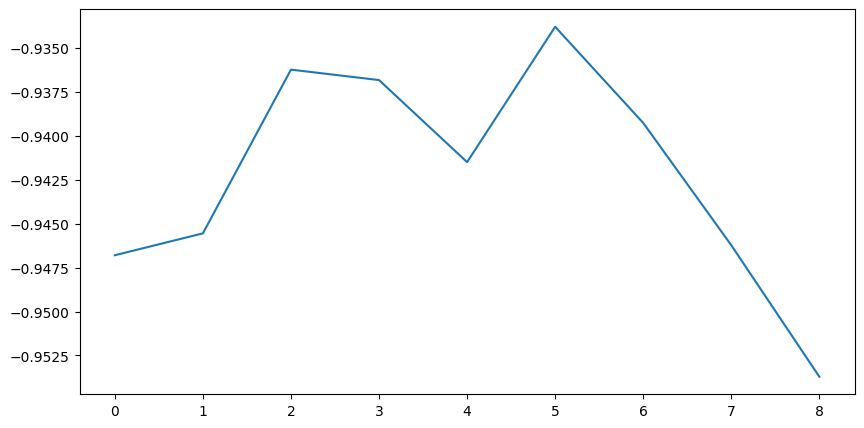

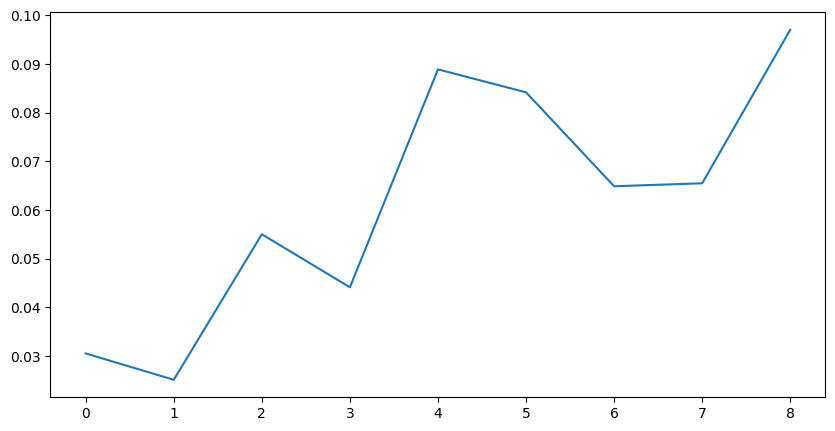

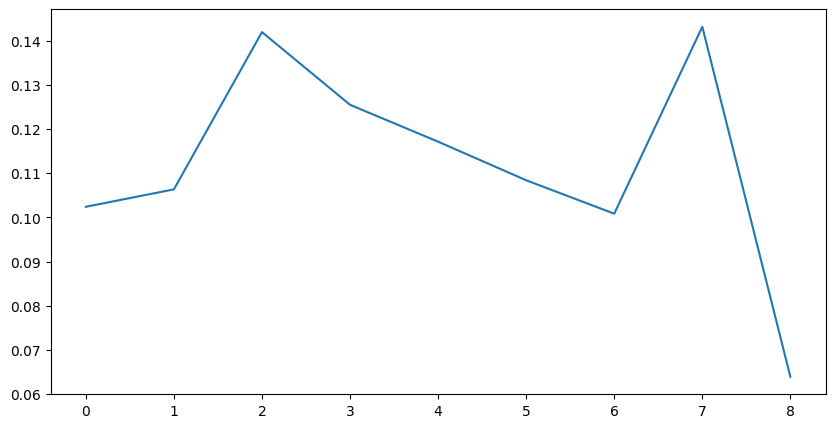

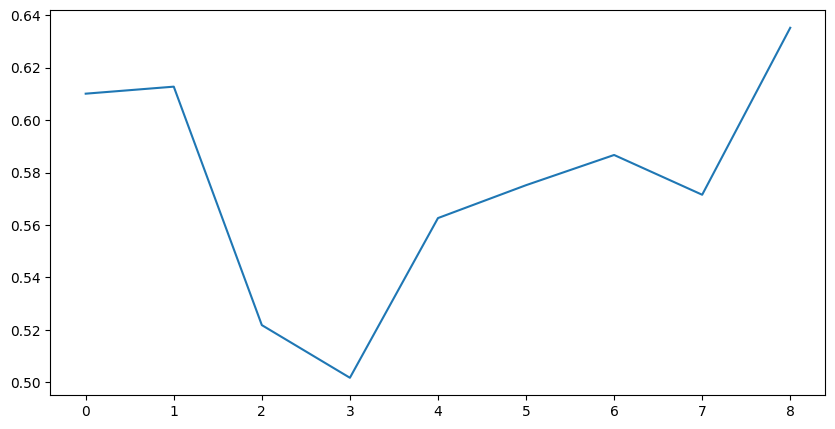

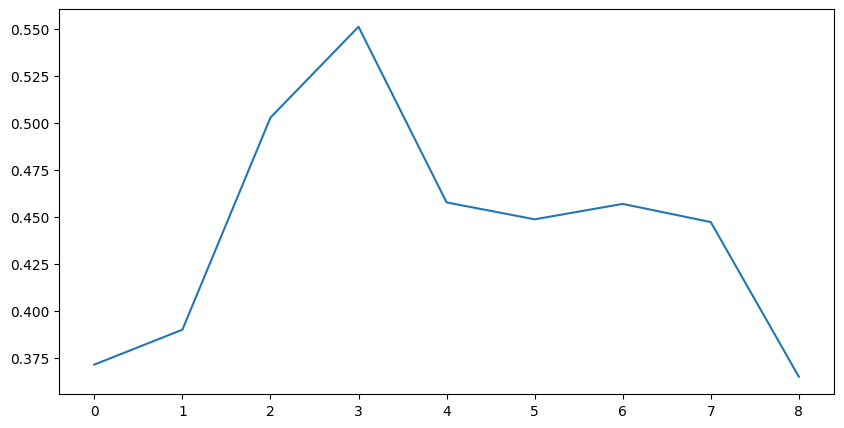

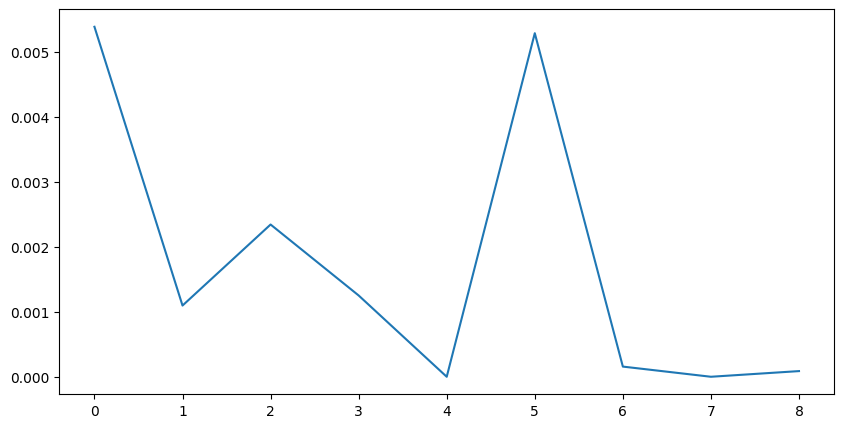

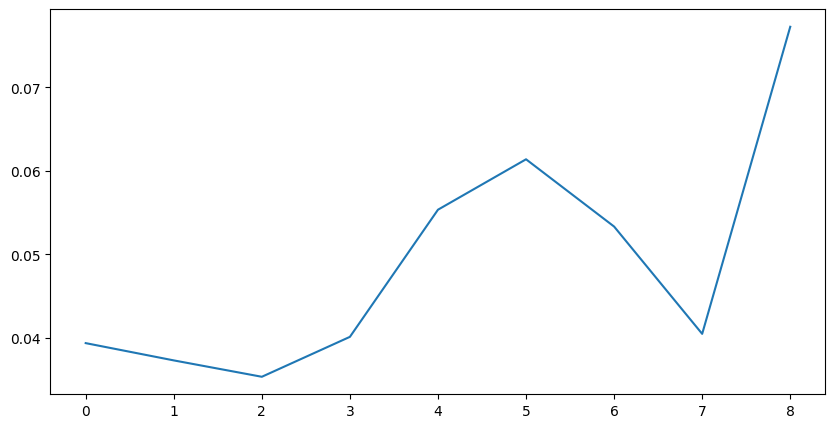

In [4]:
for i in range(7):
    fig = plt.figure(i)
    fig.set_figheight(5)
    fig.set_figwidth(10)

    plt.plot(param[:,i])

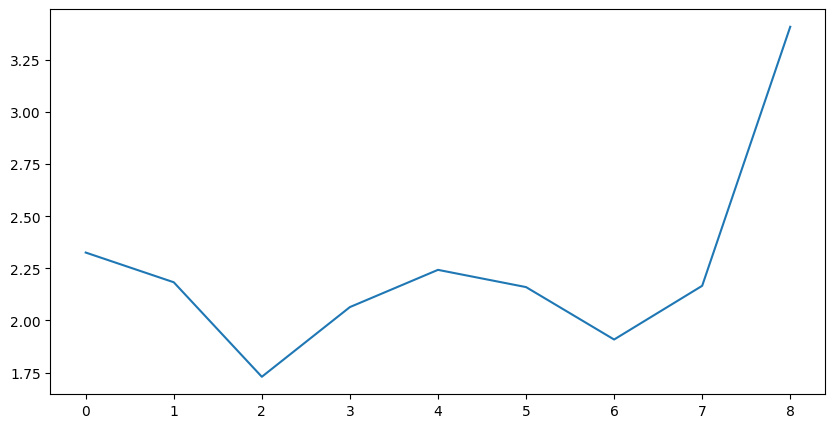

In [5]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(err)

In [6]:
df = pd.DataFrame(param, columns = ["rho", "H", "eps", "a0", "a1", "a3", "a5"])
df.to_csv("quintic_stability_parameters.csv", index = False)

In [7]:
err

array([2.32605212, 2.18334018, 1.72959356, 2.06420429, 2.24294165,
       2.1601649 , 1.90846828, 2.16632274, 3.40996862])